## IS608 - Assignment # 4 - Data Visualization in Python

James Hamski 

#### Notebook Setup and Module Import

In [91]:
%pylab inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


#### Data Import and Tidying

In [69]:
data_url = "https://raw.githubusercontent.com/jlaurito/CUNY_IS608/master/lecture4/data/riverkeeper_data_2013.csv"
raw_RiverKeeper_data = pd.read_csv(data_url)

In [70]:
raw_RiverKeeper_data.head()

,Site,Date,EnteroCount,FourDayRainTotal,SampleCount
0,Hudson above Mohawk River,10/16/2011,1733,1.5,35
1,Hudson above Mohawk River,10/21/2013,4,0.2,35
2,Hudson above Mohawk River,9/21/2013,20,0.0,35
3,Hudson above Mohawk River,8/19/2013,6,0.0,35
4,Hudson above Mohawk River,7/21/2013,31,0.0,35


In [71]:
raw_RiverKeeper_data.shape

(3397, 5)

In [72]:
raw_RiverKeeper_data.dtypes

Site                 object
Date                 object
EnteroCount          object
FourDayRainTotal    float64
SampleCount           int64
dtype: object

The first step is to get Site into a category type, Date into the date type, and EnteroCount, FourDayRainTotal, and SampleCount into their proper numeric types. 

In [73]:
rk = raw_RiverKeeper_data

*Site*

In [74]:
rk["Site"] = rk["Site"].astype('category')

*Date*

In [75]:
rk["Date"] = pd.to_datetime(rk["Date"])

*EnteroCount*
The maximum reading is 2420 cells per 100 mL, signified by ">2420". I am going to round the readings that exceed the maximum measurement to 2420 and indicate in any presentation that actual EnteroCounts may have exceeded this value.

The minimum reading is sometimes 10 cells per 100 mL, signified by < 10, and sometimes 1 cell per 100 mL, signified by < 1. This situation has a lot of potential to create misleading graphics when comparing sites with low entero concentrations. 

In [76]:
rk["EnteroCount"] = rk["EnteroCount"].str.lstrip('><')

In [77]:
rk["EnteroCount"] = rk["EnteroCount"].astype('int64')

In [78]:
rk.dtypes

Site                      category
Date                datetime64[ns]
EnteroCount                  int64
FourDayRainTotal           float64
SampleCount                  int64
dtype: object

In [79]:
rk.head()

,Site,Date,EnteroCount,FourDayRainTotal,SampleCount
0,Hudson above Mohawk River,2011-10-16,1733,1.5,35
1,Hudson above Mohawk River,2013-10-21,4,0.2,35
2,Hudson above Mohawk River,2013-09-21,20,0.0,35
3,Hudson above Mohawk River,2013-08-19,6,0.0,35
4,Hudson above Mohawk River,2013-07-21,31,0.0,35


In [105]:
site_ave = rk.groupby('Site', as_index=False).median()
site_ave = site_ave.sort_values(by='EnteroCount', ascending=False)
site_ave.head()

,Site,EnteroCount,FourDayRainTotal,SampleCount
70,Upper Sparkill Creek,411,0.1,165
45,Mohawk River at Waterford,130,0.2,35
46,Newburgh Launch Ramp,120,0.1,38
57,Piermont Pier,99,0.1,187
48,Newtown Creek- Metropolitan Ave. Bridge,98,0.4,57


#### 1. Create lists & graphs of the best and worst places to swim in the dataset.

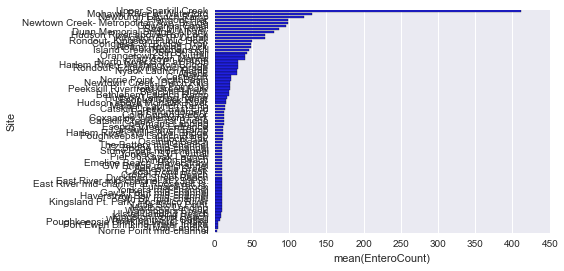

In [107]:
sns.barplot(x="EnteroCount", y="Site", data=site_ave,
            label="Total", color="b", order=site_ave['Site'])

#### 2. The testing of water quality can be sporadic. Which sites have been tested most regularly? Which ones have long gaps between tests? Pick out 5-10 sites and visually compare how regularly their water quality is tested.

First, subset the dataset. 

In [141]:
sites = rk['Site'].unique()

In [142]:
sites

[Hudson above Mohawk River, Mohawk River at Waterford, Hudson River above Troy Lock, Congress St. Bridge- Troy, Albany Rowing Dock, ..., Newtown Creek- Dutch Kills, East River mid-channel at 23rd St., Newtown Creek- Metropolitan Ave. Bridge, The Battery mid-channel, Gowanus Canal]
Length: 75
Categories (75, object): [Hudson above Mohawk River, Mohawk River at Waterford, Hudson River above Troy Lock, Congress St. Bridge- Troy, ..., East River mid-channel at 23rd St., Newtown Creek- Metropolitan Ave. Bridge, The Battery mid-channel, Gowanus Canal]

In [137]:
subset = rk[rk.Site.isin(sites_sample)]

In [138]:
subset['Site'].unique()

[Hudson above Mohawk River, Mohawk River at Waterford, Hudson River above Troy Lock]
Categories (3, object): [Hudson above Mohawk River, Mohawk River at Waterford, Hudson River above Troy Lock]

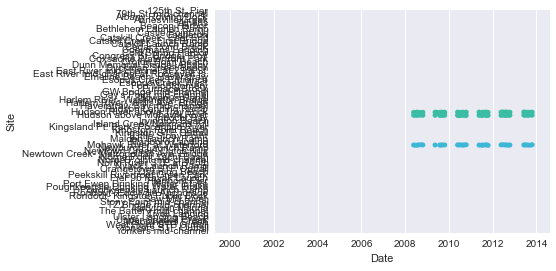

In [139]:
sns.stripplot(x="Date", y="Site", data=subset, jitter=True)

#### 3. Is there a relationship between the amount of rain and water quality?  Show this relationship graphically. If you can, estimate the effect of rain on quality at different sites and create a visualization to compare them.